# Description

This Notebook is trying to train a dataset of the middle tier of hoursing price in US metro breakdown with Random Forest Regression. We have the location info as States, and the July price of 2021 and 2020. We want to predict the housing price of July 2022

In [1]:
import numpy as np 
import pandas as pd
import pymongo
from pymongo import MongoClient

from sklearn.model_selection import train_test_split
from rfpimp import *
from sklearn.ensemble import RandomForestRegressor
import statistics

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error

# Functions we can use later

#from sklearn.metrics import accuracy_score
#import tensorflow as tf
#from sklearn.preprocessing import StandardScaler,OneHotEncoder

# I. Connect the Database

In [2]:
# Connect Mongodb with Jupyter 
# https://gist.github.com/gabefair/a28f77e3899b98f042ac74e17380fe24

client=MongoClient('localhost',27017)

In [3]:
db=client['FinalProject']

In [4]:
db

Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'FinalProject')

In [5]:
allDataconn=db['Mid_tier_County_all']
allDataCursor=allDataconn.find()
AllData_df=pd.DataFrame(list(allDataCursor))

In [6]:
AllData_df

,_id,regionName,statename,StateCodeFIPs,JulyValue16,JulyValue17,Julyvalue18,Julyvalue19,Julyvalue20,Julyvalue21,...,pop20,pop21,Unemployment_rate_2016,unemployment_rate_2017,unemployment_rate_2018,unemployment_rate_2019,unemployment_rate_2020,unemployment_rate_2021,MedHHIncome2020,MedHHIncomePercent2020
0,63094944fd4e983d03e9e559,Anchorage Borough,AK,2,317275,313457,317493,340397,328873,353655,...,290637,288121,5.3,5.4,5.0,4.5,7.8,5.8,84.0,105.8
1,63094944fd4e983d03e9e55a,Fairbanks North Star Borough,AK,2,162068,170128,174598,175471,182846,197694,...,95286,95593,5.6,5.7,5.2,4.8,6.7,5.0,76.0,95.9
2,63094944fd4e983d03e9e55b,Matanuska Susitna Borough,AK,2,272546,277072,275375,275968,271181,255532,...,107460,110686,7.9,7.7,6.9,6.2,8.7,6.8,89.0,111.9
3,63094944fd4e983d03e9e55c,Kenai Peninsula Borough,AK,2,214251,218035,216408,234044,247872,266969,...,58893,59767,8.2,7.7,7.0,6.1,9.5,7.3,68.0,85.6
4,63094944fd4e983d03e9e55d,Juneau Borough,AK,2,366085,375157,382650,396585,405685,431169,...,32195,31973,4.3,4.3,4.0,4.0,7.0,4.7,89.0,111.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2838,63094945fd4e983d03e9f06f,Johnson County,WY,56,242435,243071,250619,262658,270831,299419,...,8459,8623,5.4,4.3,4.0,3.8,5.5,4.1,62.0,93.1
2839,63094945fd4e983d03e9f070,Washakie County,WY,56,161513,163227,167660,171797,178557,194737,...,7658,7705,4.8,4.1,4.2,4.2,5.2,4.0,58.0,87.0
2840,63094945fd4e983d03e9f071,Weston County,WY,56,167357,168430,174088,181379,184954,198779,...,6809,6745,5.0,4.1,3.5,3.0,3.8,3.2,58.0,87.5
2841,63094945fd4e983d03e9f072,Crook County,WY,56,233933,238956,248180,258362,267066,291185,...,7178,7315,4.6,3.6,3.2,3.3,3.9,3.4,67.0,100.2


In [7]:
AllData_df.nunique()

_id                       2843
regionName                1715
statename                   51
StateCodeFIPs               51
JulyValue16               2567
JulyValue17               2596
Julyvalue18               2664
Julyvalue19               2714
Julyvalue20               2748
Julyvalue21               2787
JanValue22                2805
Febvalue22                2809
MarValue22                2816
AprValue22                2813
MayValue22                2817
JunValue22                2825
JulyValue22               2823
2020HousingUnits          2761
2021HousingUnits          2751
pop20                     2788
pop21                     2796
Unemployment_rate_2016     109
unemployment_rate_2017      99
unemployment_rate_2018      89
unemployment_rate_2019      90
unemployment_rate_2020     132
unemployment_rate_2021      99
MedHHIncome2020             96
MedHHIncomePercent2020     788
dtype: int64

# II. Process the Data

In [70]:
# Drop the unneeded columns and check the sample size

merge_df=AllData_df.drop(columns=['_id'])
merge_df=merge_df.dropna(how='any')
print(merge_df.shape)
merge_df.head()

(2831, 28)


,regionName,statename,StateCodeFIPs,JulyValue16,JulyValue17,Julyvalue18,Julyvalue19,Julyvalue20,Julyvalue21,JanValue22,...,pop20,pop21,Unemployment_rate_2016,unemployment_rate_2017,unemployment_rate_2018,unemployment_rate_2019,unemployment_rate_2020,unemployment_rate_2021,MedHHIncome2020,MedHHIncomePercent2020
0,Anchorage Borough,AK,2,317275,313457,317493,340397,328873,353655,356434,...,290637,288121,5.3,5.4,5.0,4.5,7.8,5.8,84.0,105.8
1,Fairbanks North Star Borough,AK,2,162068,170128,174598,175471,182846,197694,197568,...,95286,95593,5.6,5.7,5.2,4.8,6.7,5.0,76.0,95.9
2,Matanuska Susitna Borough,AK,2,272546,277072,275375,275968,271181,255532,255462,...,107460,110686,7.9,7.7,6.9,6.2,8.7,6.8,89.0,111.9
3,Kenai Peninsula Borough,AK,2,214251,218035,216408,234044,247872,266969,281956,...,58893,59767,8.2,7.7,7.0,6.1,9.5,7.3,68.0,85.6
4,Juneau Borough,AK,2,366085,375157,382650,396585,405685,431169,453888,...,32195,31973,4.3,4.3,4.0,4.0,7.0,4.7,89.0,111.6


In [9]:
# Make sure
merge_df.dtypes

regionName                 object
statename                  object
StateCodeFIPs               int64
JulyValue16                 int64
JulyValue17                 int64
Julyvalue18                 int64
Julyvalue19                 int64
Julyvalue20                 int64
Julyvalue21                 int64
JanValue22                  int64
Febvalue22                  int64
MarValue22                  int64
AprValue22                  int64
MayValue22                  int64
JunValue22                  int64
JulyValue22                 int64
2020HousingUnits            int64
2021HousingUnits            int64
pop20                       int64
pop21                       int64
Unemployment_rate_2016    float64
unemployment_rate_2017    float64
unemployment_rate_2018    float64
unemployment_rate_2019    float64
unemployment_rate_2020    float64
unemployment_rate_2021    float64
MedHHIncome2020           float64
MedHHIncomePercent2020    float64
dtype: object

In [10]:
merge_df.nunique()

regionName                1705
statename                   51
StateCodeFIPs               51
JulyValue16               2555
JulyValue17               2584
Julyvalue18               2652
Julyvalue19               2702
Julyvalue20               2736
Julyvalue21               2775
JanValue22                2793
Febvalue22                2798
MarValue22                2804
AprValue22                2801
MayValue22                2805
JunValue22                2813
JulyValue22               2811
2020HousingUnits          2749
2021HousingUnits          2739
pop20                     2776
pop21                     2785
Unemployment_rate_2016     109
unemployment_rate_2017      99
unemployment_rate_2018      89
unemployment_rate_2019      90
unemployment_rate_2020     132
unemployment_rate_2021      99
MedHHIncome2020             96
MedHHIncomePercent2020     788
dtype: int64

# III. Random Forest Model Training

- We tried five times using different features to increase the accuracy (decrease the error rate)
- We used mean_absolute_error to get the mean of the differences between predicted values and actual values. 
- We calculate the average error number and the error rate. For example, if the mid-tier housing value of a county in July 2022 is '$200,000' and our predicted price is $210,000, then the error is '$10,000' and the error rate is $10,000/$200,000=0.05, which is 5% error rate.

#### We tried to use different features to reduce the error rate. We were able to reduced the error rate by about 85%.

## 1st training: 
### Statecode+ 5 previous years' July Data => <span style="color:red">$10144 average error; 4.25% error rate</span>



In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error


In [11]:
# Set up the X feature buckets and y Target

X= merge_df[['StateCodeFIPs','JulyValue17','Julyvalue18','Julyvalue19','Julyvalue20','Julyvalue21']]
y= merge_df['JulyValue22']

In [71]:
# Start our training by having all the data as the training sets
rf = RandomForestRegressor(n_estimators=100) 
rf.fit(X, y)

predictions = rf.predict(X)
e = mean_absolute_error(y, predictions)
ep = e*100.0/y.mean()
print(f"${e:.0f} average error; {ep:.2f}% error")

$806 average error; 0.34% error


In [13]:
# Split the data sample into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 

# Set up the estimator number
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)

# Get the y prediction
y_predict=rf.predict(X_test)

# Calculate the mean of the difference between test values and actual values
validation_e = mean_absolute_error(y_test, rf.predict(X_test))

# Print out the average dollar amount error and the average error rate
print(f"${validation_e:.0f} average error; {validation_e*100.0/y.mean():.2f}% error")


$10144 average error; 4.25% error


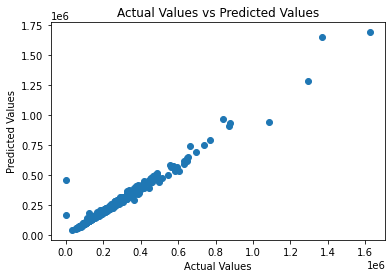

In [14]:

# Plot the pattern between the predict values and acutal values.

plt.scatter(y_test, y_predict)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual Values vs Predicted Values')
plt.show()

#### Importance

- Find the importance of each feature for it's impact to the y target

In [16]:
from rfpimp import *

# Get the importance rank by numbers
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)
I = importances(rf, X_test, y_test)
I

,Importance
Feature,
Julyvalue21,1.225622
Julyvalue20,0.071803
StateCodeFIPs,0.002308
JulyValue17,-0.001072
Julyvalue18,-0.001833
Julyvalue19,-0.002412


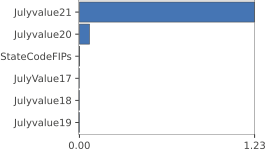

In [17]:
# Plot the importance rank 
plot_importances(I, color='#4575b4', vscale=1.8)

## 2nd training
### All 25 features (population, unemployment, housing unit, housing value, statecode, and so on) 
### => <span style="color:red">$2256 average error; 0.95% error</span>

In [23]:
# Y target is the same, but change the x features to all the value columns in the table 
# except the y value and the string columns

y=merge_df['JulyValue22']
X=merge_df.drop(columns=['JulyValue22', 'regionName','statename'])

In [24]:
# Split the data sample into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 

# Set up the estimator number
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)

# Get the y prediction
y_predict=rf.predict(X_test)

# Calculate the mean of the difference between test values and actual values
validation_e = mean_absolute_error(y_test, rf.predict(X_test))

# Print out the average dollar amount error and the average error rate
print(f"${validation_e:.0f} average error; {validation_e*100.0/y.mean():.2f}% error")


$2256 average error; 0.95% error


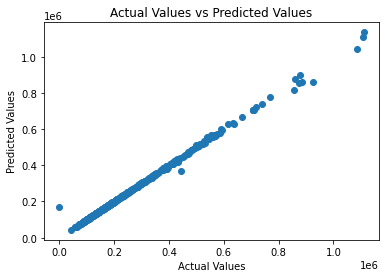

In [25]:
# Plot the pattern between the predict values and acutal values.

plt.scatter(y_test, y_predict)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual Values vs Predicted Values')
plt.show()

In [26]:
# Get the importance rank by numbers

rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)
I = importances(rf, X_test, y_test)
I

,Importance
Feature,
JunValue22,1.794334e+00
MayValue22,8.091477e-03
AprValue22,1.453661e-03
Febvalue22,1.148908e-03
JanValue22,1.008146e-03
MarValue22,7.702856e-04
unemployment_rate_2020,7.183938e-05
StateCodeFIPs,6.512891e-05
unemployment_rate_2017,5.691579e-05


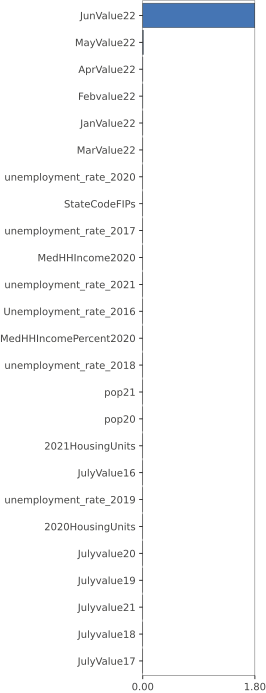

In [27]:
# # Get the importance rank graph

plot_importances(I, color='#4575b4', vscale=1.8)

## 3rd Training

### 19 features (Dropped off the bottom 6 least Important features from the rank above)
### => <span style="color:red">$1708 average error; 0.72% error</span>

In [69]:
#X, y = merge_df[['StateCodeFIPs', 'JulyValue17','Julyvalue18','Julyvalue19','Julyvalue20','Julyvalue21','JanValue22','Febvalue22','MarValue22','AprValue22','MayValue22','JunValue22']], merge_df['JulyValue22']

y=merge_df['JulyValue22']
X=merge_df.drop(columns=['JulyValue22', 'regionName','statename', 'pop20','2021HousingUnits','unemployment_rate_2019', 'MedHHIncomePercent2020', 'unemployment_rate_2021','MedHHIncome2020'])

In [29]:
# Split the data sample into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 

# Set up the estimator number
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)

# Get the y prediction
y_predict=rf.predict(X_test)

# Calculate the mean of the difference between test values and actual values
validation_e = mean_absolute_error(y_test, rf.predict(X_test))

# Print out the average dollar amount error and the average error rate
print(f"${validation_e:.0f} average error; {validation_e*100.0/y.mean():.2f}% error")


$1708 average error; 0.72% error


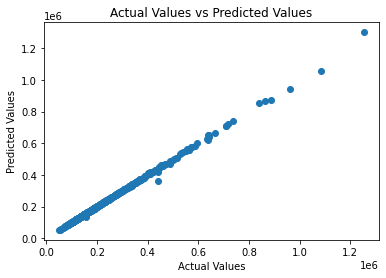

In [30]:
plt.scatter(y_test, y_predict)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual Values vs Predicted Values')
plt.show()

In [33]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)
I = importances(rf, X_test, y_test)
I

,Importance
Feature,
JunValue22,1.622067
MayValue22,0.007992
AprValue22,0.002366
MarValue22,0.001891
Febvalue22,0.001240
Julyvalue20,0.000653
JulyValue17,0.000652
unemployment_rate_2020,0.000078
JulyValue16,0.000062


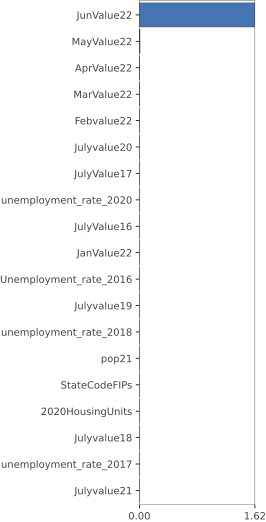

In [34]:
plot_importances(I, color='#4575b4', vscale=1.8)

## 4th Training

###  6 features (Use only the most recent month) ### => <span style="color:red">$1648 average error; 0.69% error</span>

In [35]:
X, y = merge_df[['StateCodeFIPs','JanValue22','Febvalue22','MarValue22','AprValue22','MayValue22','JunValue22']], merge_df['JulyValue22']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 

rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)

y_predict=rf.predict(X_test)

validation_e = mean_absolute_error(y_test, rf.predict(X_test))
print(f"${validation_e:.0f} average error; {validation_e*100.0/y.mean():.2f}% error")

$1648 average error; 0.69% error


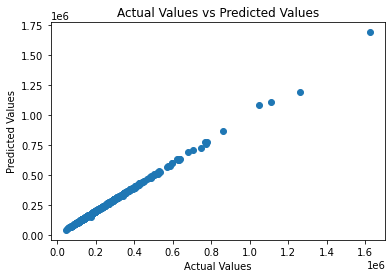

In [37]:
# Plot the pattern between the predict values and acutal values.

plt.scatter(y_test, y_predict)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual Values vs Predicted Values')
plt.show()

## Final training: 
### Statecode+3 previous years' July value (2017, 2020 & 2021) + 6 most recent month (Jan to June 2022)
### => <span style="color:red">$1475 average error; 0.62% error</span>

In [18]:
X, y = merge_df[['StateCodeFIPs','JulyValue17','Julyvalue20','Julyvalue21','JanValue22','Febvalue22','MarValue22','AprValue22','MayValue22','JunValue22']], merge_df['JulyValue22']

In [19]:
# Split the data sample into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 

# Set up the estimator number
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)

# Get the y prediction
y_predict=rf.predict(X_test)

# Calculate the mean of the difference between test values and actual values
validation_e = mean_absolute_error(y_test, rf.predict(X_test))

# Print out the average dollar amount error and the average error rate
print(f"${validation_e:.0f} average error; {validation_e*100.0/y.mean():.2f}% error")


$1475 average error; 0.62% error


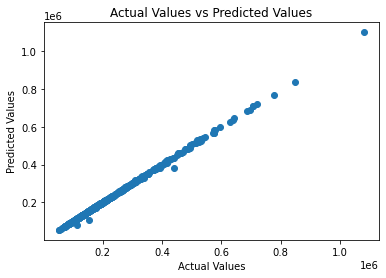

In [20]:
# Plot the pattern between the predict values and acutal values.
plt.scatter(y_test, y_predict)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual Values vs Predicted Values')
plt.show()

In [21]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)
I = importances(rf, X_test, y_test)
I

,Importance
Feature,
JunValue22,2.008691e+00
MayValue22,4.875707e-03
JulyValue17,4.096515e-03
AprValue22,1.044653e-03
MarValue22,7.533687e-04
Julyvalue20,4.567448e-04
JanValue22,3.509458e-04
Febvalue22,3.006537e-04
StateCodeFIPs,2.172333e-07


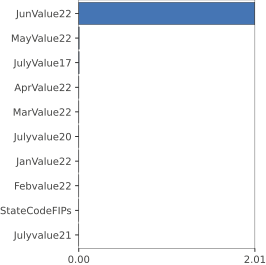

In [22]:
plot_importances(I, color='#4575b4', vscale=1.8)

## Summary

### From `$10144` average error; `4.25%` error to `$1475` average error ; `0.62%` error, we successfully reduced the error by <span style="color:red">85%</span>

## Find the Correlation

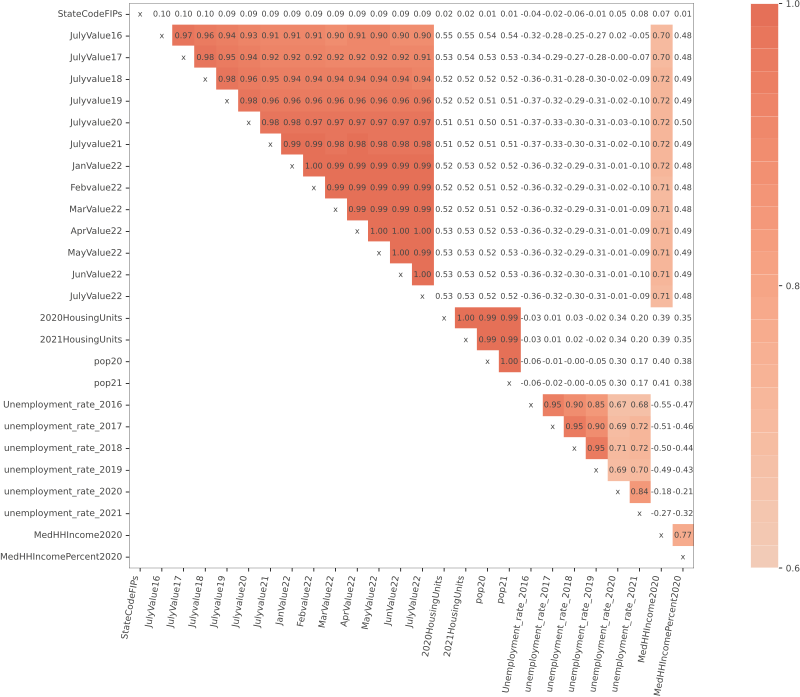

In [38]:
# Create a correlation heat map V1
base_df=merge_df.drop(columns=['regionName','statename'])
df_train, df_test = train_test_split(base_df, test_size=0.2)

from rfpimp import plot_corr_heatmap
viz = plot_corr_heatmap(df_train, figsize=(20,10))
#viz.save('../article/images/corrheatmap.svg')
viz

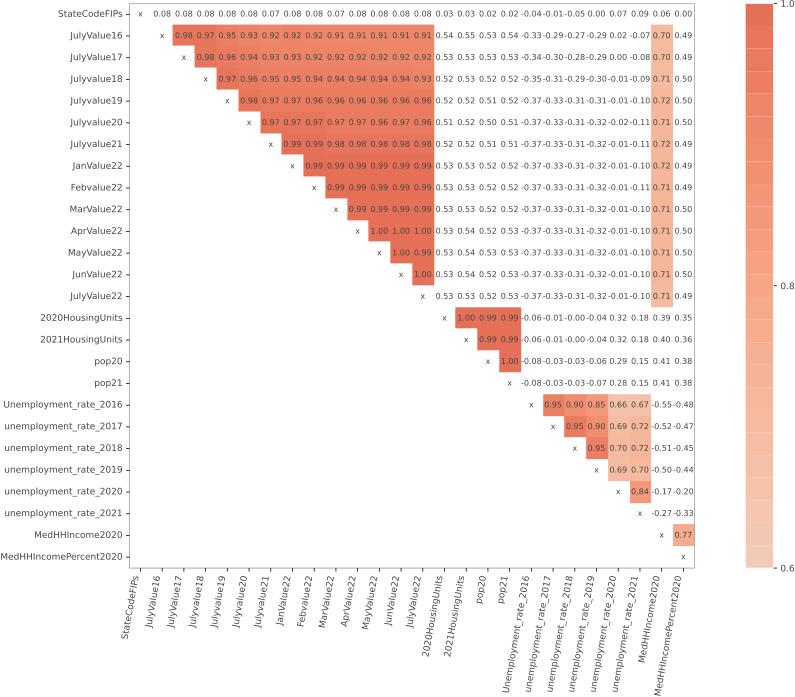

In [43]:
# Create and save a correlation heat map V2
base_df=AllData_df.drop(columns=['_id','regionName','statename'])
df_train, df_test = train_test_split(base_df, test_size=0.2)

viz = plot_corr_heatmap(df_train, figsize=(18,10))
viz.save('images/corrheatmap.svg')
viz.save('images/corrheatmap.png')
viz

## Check the dataframe of our highest accuracy training.

In [44]:
df=merge_df[['JanValue22','Febvalue22','MarValue22','AprValue22','MayValue22','JunValue22']]
df

,JanValue22,Febvalue22,MarValue22,AprValue22,MayValue22,JunValue22
0,356434,363505,367983,379289,389486,403351
1,197568,197976,195646,195065,192923,190872
2,255462,255947,257156,258130,259033,260319
3,281956,286471,287608,288643,289688,292776
4,453888,459568,459783,460032,461723,466428
...,...,...,...,...,...,...
2838,321684,329676,332268,335051,336802,339110
2839,206453,211528,213506,215324,216469,217999
2840,209418,213614,215205,216532,217027,217608
2841,312955,320155,322451,325074,326835,328776


In [45]:
df.describe().round()

,JanValue22,Febvalue22,MarValue22,AprValue22,MayValue22,JunValue22
count,2831.0,2831.0,2831.0,2831.0,2831.0,2831.0
mean,221609.0,225233.0,227879.0,231191.0,233382.0,236399.0
std,154230.0,156887.0,159351.0,161587.0,163830.0,165135.0
min,0.0,0.0,0.0,0.0,0.0,0.0
25%,126744.0,128900.0,130142.0,131207.0,131896.0,133638.0
50%,177054.0,180159.0,181772.0,183913.0,185288.0,187296.0
75%,273231.0,276706.0,279854.0,284142.0,285908.0,288064.0
max,1700343.0,1722533.0,1729343.0,1746329.0,1764168.0,1775608.0


# IV. Data Visualization

- In addition to the model training, we are interested to visualize the data by State level.
- For other data visualization of Mid-tier housing market project, [check this Tableau link for more details.](https://public.tableau.com/app/profile/bibo.wang/viz/July2022Mid-tierHomeValues/Dashboard1?publish=yes)




In [65]:
# Create a dataframe that group all the monthly median values of mid-tier homes by States
bystate=merge_df.groupby(['statename']).mean()
bystate=bystate.reset_index()
bystate.head()

,statename,StateCodeFIPs,JulyValue16,JulyValue17,Julyvalue18,Julyvalue19,Julyvalue20,Julyvalue21,JanValue22,Febvalue22,...,pop20,pop21,Unemployment_rate_2016,unemployment_rate_2017,unemployment_rate_2018,unemployment_rate_2019,unemployment_rate_2020,unemployment_rate_2021,MedHHIncome2020,MedHHIncomePercent2020
0,AK,2.0,272494.571429,277640.428571,280611.571429,292163.714286,296292.714286,312411.857143,323454.428571,327372.142857,...,87342.285714,87525.857143,6.057143,5.900000,5.571429,5.171429,8.071429,6.200000,79.142857,99.557143
1,AL,1.0,90384.061538,93973.800000,101103.507692,112219.723077,118470.353846,136084.400000,142331.784615,146251.138462,...,76980.492308,77215.215385,6.621538,5.107692,4.400000,3.581538,6.867692,3.818462,47.615385,89.272308
2,AR,5.0,72745.689189,79233.797297,85187.418919,90783.540541,96885.256757,108133.081081,116187.216216,118862.783784,...,40462.932432,40645.959459,4.636486,4.297297,4.166216,4.083784,6.368919,4.456757,44.905405,88.918919
3,AZ,4.0,177162.000000,188576.666667,201430.600000,213618.000000,227331.400000,286466.266667,323301.133333,329673.800000,...,478532.400000,485087.733333,7.773333,6.860000,6.640000,6.613333,8.780000,6.000000,53.133333,82.986667
4,CA,6.0,381988.929825,405076.912281,439197.578947,442146.456140,451709.982456,547479.456140,591716.017544,600743.824561,...,677714.456140,674081.315789,7.014035,6.136842,5.405263,5.294737,10.028070,7.373684,72.789474,88.289474


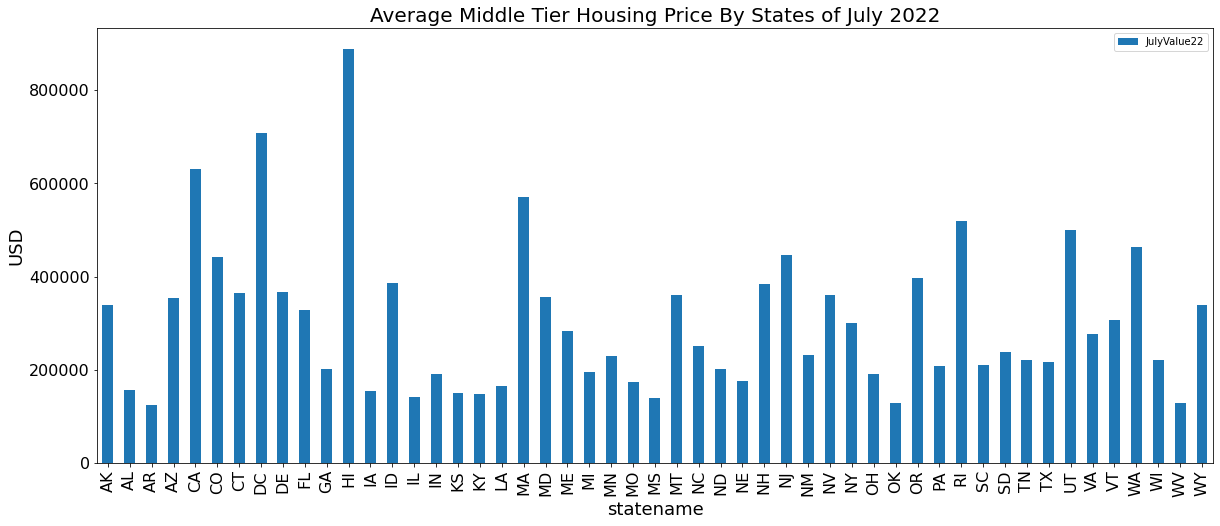

In [67]:
#Plot the "Average Middle Tier Housing Price By States of July 2022"

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# bystate.plot(kind="bar", color="red")
bystate.plot.bar('statename','JulyValue22', style='-o')
plt.xlabel('statename', size=18)
plt.ylabel('USD', size=18)
plt.xticks(rotation=90,size=16)
plt.yticks(size=16)
plt.title("Average Middle Tier Housing Price By States of July 2022", size=20)
plt.rcParams["figure.figsize"] = (20,8)
plt.show()

/Users/bibowang/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


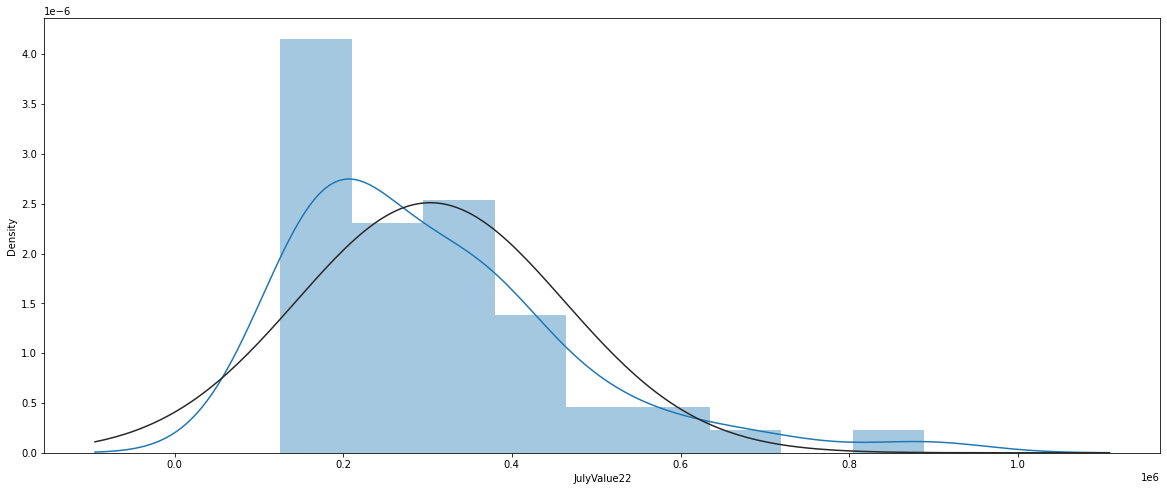

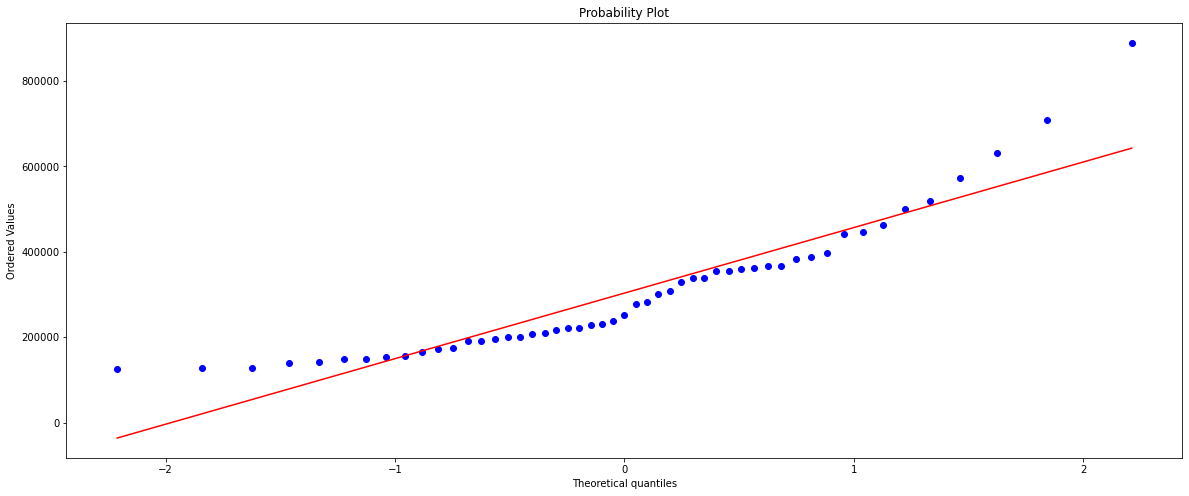

In [68]:
# Check the distribution of the July 22 data by States

sns.distplot(bystate['JulyValue22'], fit=norm);
fig = plt.figure()
res = stats.probplot(bystate['JulyValue22'], plot=plt)